In [6]:
using Plots
using LinearAlgebra
using Parameters
using Roots
using Interpolations

In [2]:
module My

using Parameters 

@with_kw struct PhysicalParam{T} @deftype Float64
    ħc = 197
    mc² = 938
    
    var"ρ/ρ₀" = 1.0
    ρ₀ = (1.36)^3/3π^2
    ρ = var"ρ/ρ₀"*ρ₀
    kF = (3π^2*ρ)^(1/3)
    eF = ħc^2/2mc² * kF^2
    
    Δk = 0.025
    Nk::Int64 = 400
    ks::T = range((1-1/2)*Δk, (Nk-1/2)*Δk, length=Nk)
    #ks::T = range((1e-2)*Δk, (Nk-1+1e-2)*Δk, length=Nk)
    
    Δr = 0.1
    Nr::Int64 = 200
    rs::T = range(Δr, Nr*Δr, length=Nr)
    
    # Gogny D1 parameters
    W::Vector{Float64} = [-402.4, -21.30]
    B::Vector{Float64} = [-100.0, -11.77]
    H::Vector{Float64} = [-496.2, 37.27]
    M::Vector{Float64} = [-23.56, -68.81]
    α = 1/3
    t₀ = 1350
    x₀ = 1
    
    vs_Gogny::Vector{Float64} = @. W - B - H + M
    as_Gogny::Vector{Float64} = [0.7, 1.2]
    
    # G3RS parameters
    vs_G3RS::Vector{Float64} = [2000, -270, -5]
    as_G3RS::Vector{Float64} = [0.447, 0.942, 2.5]
    
    interaction::Symbol = :G3RS 
    @assert interaction==:Gogny || interaction==:G3RS
    
    spectrum::Symbol = :symmetric
    @assert spectrum==:symmetric ||spectrum==:neutron || spectrum==:free
    
    #=
    matter::Symbol = :symmetry
    @assert matter==:symmetry || matter==:neutron
    =#
    
    vs::Vector{Float64} = interaction==:G3RS ? vs_G3RS : vs_Gogny
    as::Vector{Float64} = interaction==:G3RS ? as_G3RS : as_Gogny 
    @assert length(vs) === length(as)
end

end # module My

Main.My

In [3]:
param = My.PhysicalParam(interaction=:Gogny)

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  ρ/ρ₀: Float64 1.0
  ρ₀: Float64 0.0849563264400735
  ρ: Float64 0.0849563264400735
  kF: Float64 1.36
  eF: Float64 38.26286055437101
  Δk: Float64 0.025
  Nk: Int64 400
  ks: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  Δr: Float64 0.1
  Nr: Int64 200
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  W: Array{Float64}((2,)) [-402.4, -21.3]
  B: Array{Float64}((2,)) [-100.0, -11.77]
  H: Array{Float64}((2,)) [-496.2, 37.27]
  M: Array{Float64}((2,)) [-23.56, -68.81]
  α: Float64 0.3333333333333333
  t₀: Float64 1350.0
  x₀: Float64 1.0
  vs_Gogny: Array{Float64}((2,)) [170.24, -115.61000000000001]
  as_Gogny: Array{Float64}((2,)) [0.7, 1.2]
  vs_G3RS: Array{Float64}((3,)) [2000.0, -270.0, -5.0]
  as_G3RS: Array{Float64}((3,)) [0.447, 0.942, 2.5]
  interaction: Sy

### interaction in ${^{1}S}$-channel
$$
    v(r) = \sum_{i} v_{i} e^{-r^2/a_{i}^{2}}
$$

In [4]:
function calc_potential(param, rs)
    @unpack vs, as = param
    vpot = zeros(Float64, length(rs))
    for i in 1:length(vs)
        @. vpot += vs[i] * exp(-rs*rs/(as[i]*as[i]))
    end
    return vpot
end

calc_potential (generic function with 1 method)

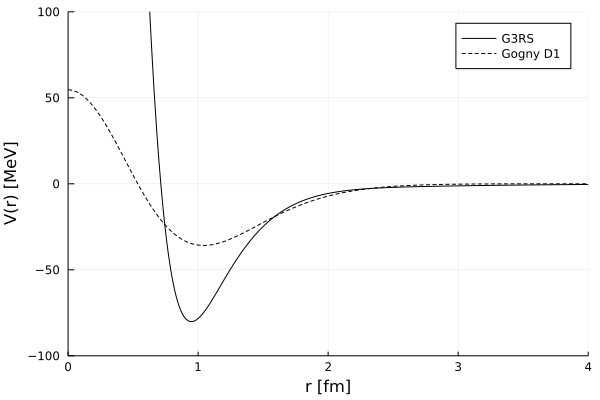

In [5]:
rs = range(0, 4, step=0.01)

param_G3RS = My.PhysicalParam(interaction=:G3RS)
vpot_G3RS = calc_potential(param_G3RS, rs)

param_Gogny = My.PhysicalParam(interaction=:Gogny)
vpot_Gogny = calc_potential(param_Gogny, rs)

p = plot(;xlim=(0,4), ylim=(-100,100), xlabel="r [fm]", ylabel="V(r) [MeV]")
plot!(p, rs, vpot_G3RS; label="G3RS", color=:black)
plot!(p, rs, vpot_Gogny; label="Gogny D1", color=:black, line=:dash)
display(p)
#savefig("di-neutron in nuclear matter figure/G3RS_GognyD1.png")

### free particle spectrum
$$
    e(k) = \frac{k^{2}}{2m}
$$

In [7]:
function free_particle_spectrum(param)
    @unpack ħc, mc², Nk, ks = param 
    es = similar(ks)
    @. es = ħc^2/2mc² * ks^2
end 

function test_free_particle_spectrum(param)
    @unpack ks = param
    @time es = free_particle_spectrum(param)
    plot(ks, es)
end

test_free_particle_spectrum (generic function with 1 method)

  0.000004 seconds (1 allocation: 3.250 KiB)


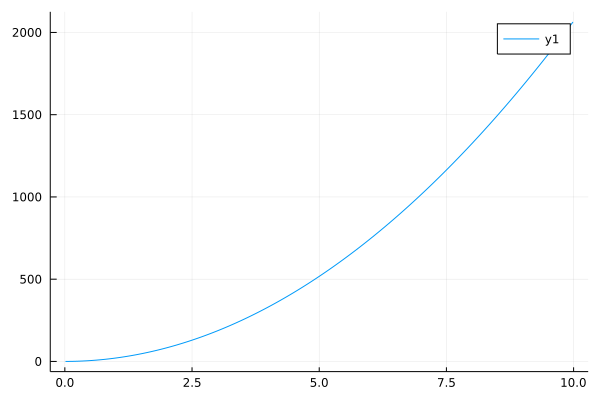

In [8]:
test_free_particle_spectrum(param)

### Gogny Hartree-Fock spectrum

対称核物質の場合：
\begin{align}
    e(k) &= \frac{\hbar^{2}k^{2}}{2m}
    + \frac{3}{8} (\alpha+2) t_{0} (2\rho_{n})^{\alpha+1}
    \\
    &\ \ \ \ \ 
    + \frac{1}{4} 2\rho_{n} 
    \sum_{i} (4W_{i} + 2B_{i} - 2H_{i} - M_{i}) \tilde{f}_{i} (0)
    \\
    &\ \ \ \ \ 
    - \sum_{i} (W_{i} + 2B_{i} - 2H_{i} - 4M_{i})
    \int \frac{d^{3}p}{(2\pi)^{3}}
    \tilde{f}_{i}(\vec{k} - \vec{p}) n(p)
\end{align}

中性子物質の場合：
\begin{align}
    e(k) 
    &= \frac{\hbar^{2}k^{2}}{2m} 
    + \frac{1}{4} (\alpha+2) t_{0} (1 - x_{0}) \rho_{n}^{\alpha+1}
    \\
    &\ \ \ \ \ 
    + \frac{1}{2} \rho_{n} 
    \sum_{i} (2W_{i} + B_{i} - 2H_{i} - M_{i}) \tilde{f}_{i} (0)
    \\
    &\ \ \ \ \ 
    - \sum_{i} (W_{i} + 2B_{i} - H_{i} - 2M_{i})
    \int \frac{d^{3}p}{(2\pi)^{3}}
    \tilde{f}_{i}(\vec{k} - \vec{p}) n(p)
\end{align}

ただし、
$$
    \tilde{f}_{i} (\vec{p}) 
    = \int d^{3}r \, \exp(-i\vec{p} \cdot \vec{r}) 
    \exp(-r^{2}/\mu_{i}^{2})
    = (\sqrt{\pi} \mu_{i})^{3} 
    \exp(-\mu_{i}^{2} p^{2}/4)
$$

$$
    n(p) = \frac{1}{2}\left(1 - \frac{e(p)-\mu}{E(p)}\right)
$$
である。

交換項の角度積分を実行すると、
$$
    \int \frac{d^{3}p}{(2\pi)^{3}}
    \tilde{f}_{i}(\vec{k} - \vec{p}) n(p)
    = \frac{\mu_{i}}{2\sqrt{\pi}k}
    \int_{0}^{\infty} dp\, p \, n(p) 
    \left[
        e^{-\frac{1}{4} \mu_{i}^{2} (p-k)^{2}}
        - e^{-\frac{1}{4} \mu_{i}^{2} (p+k)^{2}}
    \right]
$$
となる。

In [37]:
function second_deriv_coeff(i, j, a, N, Π) 
    d = 0.0 
    if i === 1
        d += ifelse(j===3, -1/12, 0)
        d += ifelse(j===2,   4/3 + Π*(-1/12), 0)
        d += ifelse(j===1,  -5/2 + Π*(4/3), 0)
    elseif i === 2
        d += ifelse(j===4, -1/12, 0)
        d += ifelse(j===3, 4/3, 0)
        d += ifelse(j===2, -5/2, 0)
        d += ifelse(j===1, 4/3 + Π*(-1/12), 0)
    elseif i === N-1
        d += ifelse(j===N, 4/3, 0)
        d += ifelse(j===N-1, -5/2, 0)
        d += ifelse(j===N-2, 4/3, 0)
        d += ifelse(j===N-3, -1/12, 0)
    elseif i === N 
        d += ifelse(j===N, -5/2, 0)
        d += ifelse(j===N-1, 4/3, 0)
        d += ifelse(j===N-2, -1/12, 0)
    else
        d += ifelse(j===i+2, -1/12, 0)
        d += ifelse(j===i+1, 4/3, 0)
        d += ifelse(j===i, -5/2, 0)
        d += ifelse(j===i-1, 4/3, 0)
        d += ifelse(j===i-2, -1/12, 0)
    end
    d /= a*a 
    return d 
end

function second_deriv!(d²ψ, param, ψ, Π)
    @unpack Nk, Δk, ks = param 
    Nk = length(ks)
    
    fill!(d²ψ, 0)
    for ik in 1:Nk
        for dk in -2:2 
            jk = ik + dk
            if !(1 ≤ jk ≤ Nk) continue end 

            d²ψ[ik] += second_deriv_coeff(ik, jk, Δk, Nk, Π)*ψ[jk]
        end
    end
    
    return
end


second_deriv! (generic function with 1 method)

In [14]:
function single_particle_spectrum!(es_new, param, es, Δs, μ)
    @unpack ħc, mc², ρ, kF, Δk, Nk, ks,
    W, B, H, M, α, t₀, x₀, vs_Gogny, as_Gogny, spectrum = param
    Δp = Δk
    
    fill!(es_new, 0)
    
    # kinetic term
    @. es_new += ħc^2/2mc² * ks^2
    
    if spectrum==:free 
        return
    end
    
    if param.interaction==:G3RS 
        emc² = 1/mc²
        for i in 1:length(vs_Gogny)
            a = as_Gogny[i]
            
            v = W[i]+2B[i]-2H[i]-4M[i]
            if spectrum===:neutron
                v = W[i]+2B[i]-H[i]-2M[i]
            end
            
            x = kF^2 * a^2 / 2
            emc² += 1/2ħc^2 * kF/sqrt(π) * v * a^3 *
                exp(-x)*(cosh(x)/x - sinh(x)/x^2)
        end
        emc² = 1/emc²
        @. es_new = ħc^2/2emc² * ks^2
        #@show emc²/mc²
        return
    end
    
    # t₀ term
    if spectrum==:symmetric
        @. es_new += (3/8)*(α+2)*t₀*(2ρ)^(α+1)
    else
        @. es_new += (1/4)*(α+2)*t₀*(1 - x₀)*ρ^(α+1)
    end
    
    #=
    if param.interaction==:G3RS
        es = free_particle_spectrum(param)
        Δs = zeros(Float64, Nk)
        μ = kF
    end
    =#
    
    for i in 1:length(vs_Gogny)
        a = as_Gogny[i]
        
        # gaussian direct term
        v = 4W[i]+2B[i]-2H[i]-M[i]
        if spectrum===:neutron
            v = 2W[i]+ B[i]-2H[i]-M[i]
        end
        @. es_new += (ρ/2)*v*(√π*a)^3 #*exp(-a^2*ks^2/4)
        
        # gaussian exchange term 
        v = W[i]+2B[i]-2H[i]-4M[i]
        if spectrum===:neutron
            v = W[i]+2B[i]-H[i]-2M[i]
        end
        for ik in 1:Nk, ip in 1:Nk
            k = ks[ik]

            p = ks[ip]
            if p > kF continue end
            
            e = es[ip]
            E = sqrt((e-μ)^2 + Δs[ip]^2)
            occ = (1/2)*(1 - (e-μ)/E)
            es_new[ik] += -v*a/(2*√π*k)*Δp*p*
                (exp(-a^2*(p-k)^2/4) - exp(-a^2*(p+k)^2/4))
        end
    end
    
    
    #=
    if param.interaction==:G3RS
        d²es_Gogny = similar(es_new)
        second_deriv!(d²es_Gogny, param, es_new, 1)
        
        #ikF = length(ks[ks .< kF])
        ikF = 0
        for ik in 1:Nk 
            if ks[ik] ≤ kF 
                ikF = ik
            end
        end
        emc² = ħc^2/d²es_Gogny[ikF]

        #@show emc²/mc²

        @. es_new = ħc^2/2emc² * ks^2
    end
    =# 
    
    return 
end


function test_single_particle_spectrum(param)
    @unpack mc², Nk, ks, eF = param
    es = free_particle_spectrum(param)
    Δs = zeros(Float64, Nk)
    
    
    param = My.PhysicalParam(spectrum=:free, interaction=:Gogny)
    es_free = similar(es)
    @time single_particle_spectrum!(es_free, param, es, Δs, eF)
    
    param = My.PhysicalParam(spectrum=:symmetric, interaction=:Gogny)
    es_Gogny_symm = similar(es)
    @time single_particle_spectrum!(es_Gogny_symm, param, es, Δs, eF)
    
    param = My.PhysicalParam(spectrum=:neutron, interaction=:Gogny)
    es_Gogny_neut = similar(es)
    @time single_particle_spectrum!(es_Gogny_neut, param, es, Δs, eF)

    
    param = My.PhysicalParam(spectrum=:symmetric, interaction=:G3RS)
    es_G3RS_symm = similar(es)
    @time single_particle_spectrum!(es_G3RS_symm, param, es, Δs, eF)
    #@show emc²_G3RS_symm/mc²
    
    param = My.PhysicalParam(spectrum=:neutron, interaction=:G3RS)
    es_G3RS_neut = similar(es)
    @time single_particle_spectrum!(es_G3RS_neut, param, es, Δs, eF)
    #@show emc²_G3RS_neut/mc²
    
    
    p = plot(xlim=(0, 5), ylim=(-100, 500), legend=:topleft, 
        xlabel="k [fm⁻¹]", ylabel="e(k) [MeV]")
    plot!(p, ks, es_free; label="free")
    plot!(p, ks, es_Gogny_symm; label="Gogny symm")
    plot!(p, ks, es_Gogny_neut; label="Gogny neut")
    plot!(p, ks, es_G3RS_symm; label="G3RS symm")
    plot!(p, ks, es_G3RS_neut; label="G3RS neut")
end



test_single_particle_spectrum (generic function with 1 method)

  0.000007 seconds
  0.002210 seconds
  0.002238 seconds
  0.000004 seconds
  0.000004 seconds


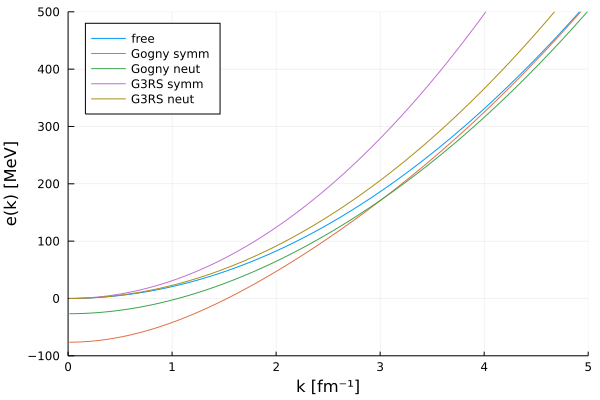

In [15]:
test_single_particle_spectrum(param)

### number equation 
$$
    \rho = \frac{1}{2\pi^{2}} \int_{0}^{\infty} dk\, k^{2} 
    \left(1 - \frac{e(k) - \mu}{E(k)}\right)
$$

In [16]:
function number_equation(param, es, Δs, μ)
    @unpack ρ, Δk, Nk, ks = param 
    
    f = 0.0
    for ik in 1:Nk
        k = ks[ik]
        e = es[ik]
        Δ = Δs[ik]
        E = sqrt((e-μ)^2 + Δ^2)
        f += Δk*k*k*(1 - (e-μ)/E)
    end
    f *= 1/2π^2
    f -= ρ
end

function test_number_equation(param, Δ, μs)
    @unpack eF, Nk = param
    Δs = fill(Δ, Nk)
    
    es = free_particle_spectrum(param)
    
    Nμ = length(μs)
    fs = similar(μs)
    
    @time for iμ in 1:Nμ
        fs[iμ] = number_equation(param, es, Δs, μs[iμ])
    end
    
    @show eF
    
    plot(μs, fs; label="number equation", legend=:topleft)
    plot!(μs, fill(0, length(μs)); label="0")
    plot!([eF], [0]; marker=:dot, label="eF")
end



test_number_equation (generic function with 1 method)

  0.004826 seconds
eF = 9.565715138592752


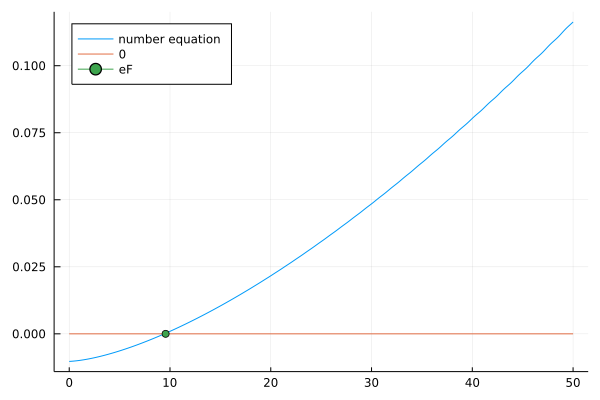

In [17]:
Δ = 1.0
μs = range(0, 50, length=2000)
param = My.PhysicalParam(Nk=400, Δk=0.025, var"ρ/ρ₀"=1/8)
test_number_equation(param, Δ, μs)

In [18]:
function solve_number_equation(param, es, Δs; μ_min=-param.eF*10000, μ_max=param.eF*100)
    f(μ) = number_equation(param, es, Δs, μ)
    if f(μ_min)*f(μ_max) > 0
        @show f(μ_min) f(μ_max)
        μs = range(μ_min, μ_max, length=1000)
        p = plot()
        #p = plot(ks, Δs)
        plot!(p, μs, f.(μs))
        display(p)
    end
    find_zero(f, (μ_min, μ_max), Bisection())
end

function test_solve_number_equation(param, Δ)
    @unpack eF, Nk = param
    Δs = fill(Δ, Nk)
    es = free_particle_spectrum(param)
    
    @time μ = solve_number_equation(param, es, Δs)
    @show μ eF
    return 
end

test_solve_number_equation (generic function with 1 method)

In [19]:
Δ= 1.0
param = My.PhysicalParam(var"ρ/ρ₀"=1.0)
test_solve_number_equation(param, Δ)

  0.353638 seconds (728.33 k allocations: 42.849 MiB, 5.75% gc time, 99.67% compilation time)
μ = 38.233618560108724
eF = 38.26286055437101


### gap equation 

$$
    \Delta(p) = 
    - \sum_{i} \frac{v_{i} \mu_{i}}{4 \sqrt{\pi} p}
    \int_{0}^{\infty} dk \, k \left[
    e^{-\mu_{i}^{2}(p-k)^{2}/4} 
    - e^{-\mu_{i}^{2}(p+k)^{2}/4}
    \right] \frac{\Delta(k)}{E(k)}
$$

In [20]:
function calc_gap!(Δs_new, param, es, Δs, μ)
    @unpack Δk, Nk, ks, vs, as = param
    
    fill!(Δs_new, 0)
    for i in 1:length(vs), ip in 1:Nk, ik in 1:Nk
        v = vs[i]
        a = as[i]
        
        p = ks[ip]
        
        k = ks[ik]
        Δ = Δs[ik]
        E = sqrt((es[ik]-μ)^2 + Δ^2)
        
        Δs_new[ip] += -v*a/(4*√π*p)*Δk*k*
            (exp(-(1/4)*a^2*(p-k)^2) - exp(-(1/4)*a^2*(p+k)^2))*Δ/E
    end
    
    return
end

function test_calc_gap(param, Δ₀)
    @unpack eF, Nk, ks = param
    Δs = fill(Δ₀, Nk)
    es = free_particle_spectrum(param)
    
    μ = solve_number_equation(param, es, Δs)
    
    Δs_new = similar(Δs)
    @time calc_gap!(Δs_new, param, es, Δs, μ)
    
    p = plot()
    plot!(p, ks, Δs; label="Δs")
    plot!(p, ks, Δs_new; label="Δs_new")
end
     

test_calc_gap (generic function with 1 method)

  0.017368 seconds


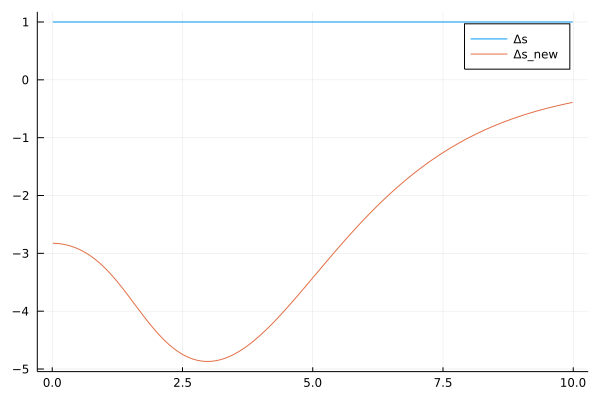

In [21]:
Δ₀ = 1.0
test_calc_gap(param, Δ₀)

In [22]:
function solve_gap_equation(param, Δ₀; iter_max=1000, χ=0.3, rtol=1e-5, show_result=false)
    @unpack ks, Nk = param
    
    es = free_particle_spectrum(param)
    es_new = similar(es)
    
    Δs = fill(Δ₀, Nk)
    Δs_new = similar(Δs)
    
    μ = solve_number_equation(param, es, Δs)
    
    Δ²_diff = Float64[]
    
    n_plot = 10
    plot_interval = div(iter_max, n_plot)
    
    if show_result
        p = plot(xlabel="k [fm⁻¹]", ylabel="Δ [MeV]", legend=false)
        q = plot(xlabel="k [fm⁻¹]", ylabel="e [MeV]", legend=false, 
            xlim=(0, 5), ylim=(-100, 500))
    end
    for iter in 1:iter_max
        single_particle_spectrum!(es_new, param, es, Δs, μ)
        if (show_result && iter%n_plot === 0)
            plot!(q, ks, es_new)
        end
        @. es = (es + χ*es_new)/(1 + χ)
        if (show_result && iter%n_plot === 0)
            plot!(q, ks, es)
        end
        
        calc_gap!(Δs_new, param, es, Δs, μ)
        
        if (show_result && iter%n_plot === 0)
            plot!(p, ks, Δs_new)
        end
        
        Δ² = sum(@. Δs^2)
        Δ²_new = sum(@. Δs_new^2)
        push!(Δ²_diff, Δ²-Δ²_new)
        if iter > 1 && isapprox(Δ², Δ²_new, rtol=rtol)
            if show_result
                println("iteration converged at iter=$iter")
            end
            break
        end
        
        if iter > 1 
            @. Δs = (Δs + χ*Δs_new)/(1 + χ)
        else
            @. Δs = Δs_new
        end
        
        
        if (show_result && iter%plot_interval === 0)
            #@show Δ Δ_new
            plot!(p, ks, Δs)
        end
        
        μ = solve_number_equation(param, es, Δs)
    end
    if show_result
        display(p)
        display(q)
    end
    
    if show_result
        p = plot(xlabel="k [fm⁻¹]", ylabel="Δ [MeV]")
        plot!(p, ks, Δs)
        display(p)
        
        #=
        p = plot(Δ²_diff; xlabel="iter", ylabel="|Δs|² - |Δs_new|² [MeV²]")
        display(p)
        =#
    end
    
    return es, Δs, μ
end

function test_solve_gap_equation(param, Δ₀; iter_max=1000, χ=0.3, rtol=1e-5, show_result=true)
    @unpack eF, kF, Nk, ks = param
    
    @time es, Δs, μ = solve_gap_equation(param, Δ₀; iter_max=iter_max, χ=χ, rtol=rtol, show_result=show_result)
    
    itp_Δs = CubicSplineInterpolation(ks, Δs)
    @show kF itp_Δs(kF)
    
    return 
end

test_solve_gap_equation (generic function with 1 method)

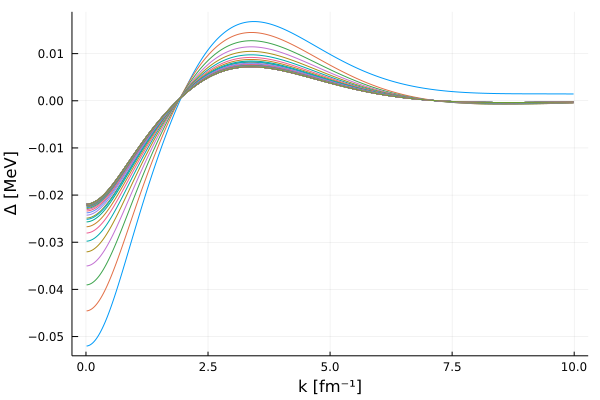

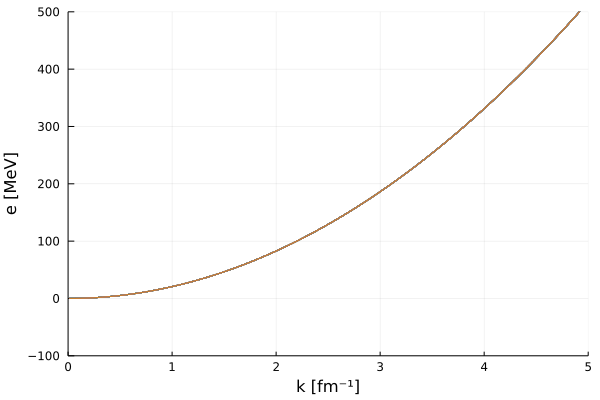

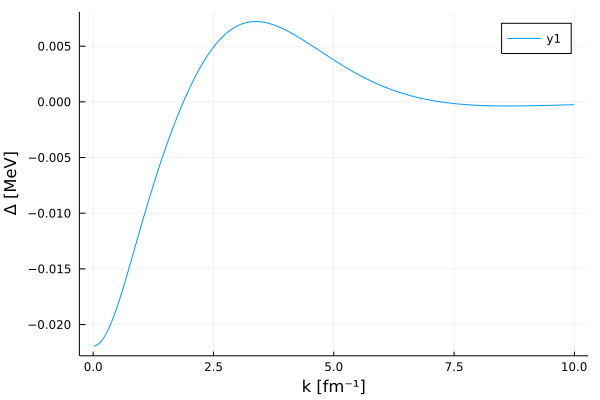

iteration converged at iter=443
  6.766681 seconds (585.27 k allocations: 33.737 MiB, 0.28% gc time)
kF = 0.0631256081371338
itp_Δs(kF) = -0.021870766277985808


In [30]:
Δ₀ = 1.0
param = My.PhysicalParam(var"ρ/ρ₀"=1e-4, interaction=:G3RS, spectrum=:symmetric)
test_solve_gap_equation(param, Δ₀; iter_max=1000)

### Cooper pair wave function 
\begin{align}
    \Psi_{\mathrm{pair}}(r)
    &= \frac{C}{(2\pi)^{3}} \int d^{3}{k} \frac{\Delta(k)}{2E(k)} 
    e^{i \vec{k} \cdot \vec{r}}
    \\
    &= \frac{C}{4\pi^{2}r} \int_{0}^{\infty} dk\, k 
    \frac{\Delta(k)}{E(k)} \sin (kr)
\end{align}

### norm 
\begin{align}
    \int d^{3}r \, |\Psi_{\mathrm{pair}}(r)|^{2}
    = \frac{|C|^{2}}{2\pi^{2}} \int_{0}^{\infty} dk \, k^{2}
    \left(\frac{\Delta(k)}{2E(k)}\right)^{2}
\end{align}

### root-mean-square radius
\begin{align}
    \xi_{rms}^{2}
    = \frac{
        \displaystyle
        \frac{1}{2\pi^{2}} \int_{0}^{\infty} dk \, k^{2}
        \left(
            \frac{\partial}{\partial k} 
            \frac{\Delta(k)}{2E(k)}
        \right)^{2}
    }{
        \displaystyle
        \frac{1}{2\pi^{2}} \int_{0}^{\infty} dk \, k^{2}
        \left(\frac{\Delta(k)}{2E(k)}\right)^{2}
    }
\end{align}

In [27]:
function calc_norm(param, es, Δs, μ)
    @unpack Δk, Nk, ks = param 
    
    N² = 0.0
    for ik in 1:Nk
        k = ks[ik]
        Δ = Δs[ik]
        E = sqrt((es[ik]-μ)^2 + Δ^2)
        
        N² += Δk*k*k*(Δ/2E)^2
    end
    N² *= 1/2π^2
    
    N = sqrt(N²)
end

#=
function calc_rmsr(param, es, Δs, μ)
    @unpack Δk, Nk, ks = param 
    
    ξ² = 0.0
    
    Es = @. sqrt((es - μ)^2 + Δs^2)
    
    k = ks[1]
    ξ² += Δk*k*k*((Δs[1]/2Es[1] - Δs[2]/2Es[2])/2Δk)^2
    
    for ik in 2:Nk-1
        k = ks[ik]
        ξ² += Δk*k*k*((Δs[ik-1]/2Es[ik-1] - Δs[ik+1]/2Es[ik+1])/2Δk)^2
    end
    
    k = ks[Nk]
    ξ² += Δk*k*k*((Δs[Nk-1]/2Es[Nk-1] - 0)/2Δk)^2
    
    ξ² *= 1/2π^2
    
    ξ = sqrt(ξ²)
    ξ /= calc_norm(param, es, Δs, μ)
end
=#

#=
@inline function first_deriv_coeff(i, j, a, N) 
    d = 0.0 
    if i === 1
        d += ifelse(j===3, -1/12, 0)
        d += ifelse(j===2,   2/3, 0)
    elseif i === 2
        d += ifelse(j===4, -1/12, 0)
        d += ifelse(j===3,   2/3, 0)
        d += ifelse(j===1,  -2/3, 0)
    elseif i === N-1
        d += ifelse(j===N,    2/3, 0)
        d += ifelse(j===N-2, -2/3, 0)
        d += ifelse(j===N-3, 1/12, 0)
    elseif i === N 
        d += ifelse(j===N-1, -2/3, 0)
        d += ifelse(j===N-2, 1/12, 0)
    else
        d += ifelse(j===i+2, -1/12, 0)
        d += ifelse(j===i+1,   2/3, 0)
        d += ifelse(j===i-1,  -2/3, 0)
        d += ifelse(j===i-2,  1/12, 0)
    end
    d /= a
    return d 
end

function first_deriv!(dψ, param, ψ)
    @unpack Nk, Δk, ks = param 
    Nk = length(ks)
    
    fill!(dψ, 0)
    for ik in 1:Nk
        for dk in -2:2 
            jk = ik + dk
            if !(1 ≤ jk ≤ Nk) continue end 

            dψ[ik] += first_deriv_coeff(ik, jk, Δk, Nk)*ψ[jk]
        end
    end
    
    return
end
=#

function first_deriv_coeff(i, j, a, N, Π) 
    d = 0.0 
    if i === 1
        d += ifelse(j===3, -1/12           , 0)
        d += ifelse(j===2,   2/3 + Π*(1/12), 0)
        d += ifelse(j===1,     0 + Π*(-2/3), 0)
    elseif i === 2
        d += ifelse(j===4, -1/12           , 0)
        d += ifelse(j===3,   2/3           , 0)
        d += ifelse(j===1,  -2/3 + Π*(1/12), 0)
    elseif i === N-1
        d += ifelse(j===N,    2/3, 0)
        d += ifelse(j===N-2, -2/3, 0)
        d += ifelse(j===N-3, 1/12, 0)
    elseif i === N 
        d += ifelse(j===N-1, -2/3, 0)
        d += ifelse(j===N-2, 1/12, 0)
    else
        d += ifelse(j===i+2, -1/12, 0)
        d += ifelse(j===i+1,   2/3, 0)
        d += ifelse(j===i-1,  -2/3, 0)
        d += ifelse(j===i-2,  1/12, 0)
    end
    d /= a
    return d 
end


function first_deriv!(dψ, param, ψ, Π)
    @unpack Nk, Δk, ks = param 
    Nk = length(ks)
    
    fill!(dψ, 0)
    for ik in 1:Nk
        for dk in -2:2 
            jk = ik + dk
            if !(1 ≤ jk ≤ Nk) continue end 

            dψ[ik] += first_deriv_coeff(ik, jk, Δk, Nk, Π)*ψ[jk]
        end
    end
    
    return
end


function calc_rmsr(param, es, Δs, μ)
    @unpack Δk, Nk, ks = param 
    
    ξ² = 0.0
    
    Es = @. sqrt((es - μ)^2 + Δs^2)
    var"(d/dk)(Δ/2E)" = similar(ks)
    first_deriv!(var"(d/dk)(Δ/2E)", param, (@. Δs/2Es), 1)
    
    ξ² = 0.0
    for ik in 1:Nk
        k = ks[ik]
            
        ξ² += Δk*k*k*(var"(d/dk)(Δ/2E)"[ik])^2
    end
    
    ξ² *= 1/2π^2
    
    ξ = sqrt(ξ²)
    ξ /= calc_norm(param, es, Δs, μ)
end


function test_calc_rmsr(param)
    @unpack eF, kF, Nk, ks = param
    
    @time es, Δs, μ = solve_gap_equation(param, Δ₀)
    
    @time N = calc_norm(param, es, Δs, μ)
    @time ξ = calc_rmsr(param, es, Δs, μ)
    @show N ξ
    
    return
end

test_calc_rmsr (generic function with 1 method)

In [29]:
param = My.PhysicalParam(var"ρ/ρ₀"=1, Nk=100, Δk=0.1, interaction=:G3RS, spectrum=:symmetric)
test_calc_rmsr(param)

  0.157283 seconds (2.84 k allocations: 387.859 KiB)
  0.000005 seconds (2 allocations: 352 bytes)
  0.000014 seconds (9 allocations: 3.000 KiB)
N = 0.0475531990041352
ξ = 9.186234249192488


In [31]:
var"ρ/ρ₀" = 10 .^ range(-4, 0, step=0.25)

ΔF_Gogny_free = similar(var"ρ/ρ₀")
ΔF_Gogny_neut = similar(var"ρ/ρ₀")
ΔF_Gogny_symm = similar(var"ρ/ρ₀")

ΔF_G3RS_free = similar(var"ρ/ρ₀")
ΔF_G3RS_neut = similar(var"ρ/ρ₀")
ΔF_G3RS_symm = similar(var"ρ/ρ₀")

eF = similar(var"ρ/ρ₀")
Δ₀ = 1.0

ξ_Gogny_neut = similar(var"ρ/ρ₀")
ξ_Gogny_symm = similar(var"ρ/ρ₀")

ξ_G3RS_neut = similar(var"ρ/ρ₀")
ξ_G3RS_symm = similar(var"ρ/ρ₀")

Nk = 1000
Δk = 0.01

for i in 1:length(var"ρ/ρ₀")
    # Gogny for free spectrum
    param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀"[i], Δk=Δk, Nk=Nk, 
        interaction=:Gogny, spectrum=:free)
    
    es, Δs, μ = solve_gap_equation(param, Δ₀)
    itp_Δs = CubicSplineInterpolation(param.ks, Δs)
    ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) 
    @show ΔF_Gogny_free[i]
    
    # Gogny for neutron matter
    param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀"[i], Δk=Δk, Nk=Nk, 
        interaction=:Gogny, spectrum=:neutron)
    
    es, Δs, μ = solve_gap_equation(param, Δ₀)
    itp_Δs = CubicSplineInterpolation(param.ks, Δs)
    ΔF_Gogny_neut[i] = abs(itp_Δs(param.kF)) 
    ξ_Gogny_neut[i] = calc_rmsr(param, es, Δs, μ)
    @show ΔF_Gogny_neut[i]
    
    # Gogny for symmetric matter
    param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀"[i], Δk=Δk, Nk=Nk, 
        interaction=:Gogny, spectrum=:symmetric)
    
    es, Δs, μ = solve_gap_equation(param, Δ₀)
    itp_Δs = CubicSplineInterpolation(param.ks, Δs)
    ΔF_Gogny_symm[i] = abs(itp_Δs(param.kF))
    ξ_Gogny_symm[i] = calc_rmsr(param, es, Δs, μ)
    @show ΔF_Gogny_symm[i]
    
    # G3RS for free spectrum
    param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀"[i], Δk=Δk, Nk=Nk, 
        interaction=:G3RS, spectrum=:free)
    
    es, Δs, μ = solve_gap_equation(param, Δ₀)
    itp_Δs = CubicSplineInterpolation(param.ks, Δs)
    ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) 
    @show ΔF_G3RS_free[i]
    
    # G3RS for neutron matter
    param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀"[i], Δk=Δk, Nk=Nk, 
        interaction=:G3RS, spectrum=:neutron)
    
    es, Δs, μ = solve_gap_equation(param, Δ₀)
    itp_Δs = CubicSplineInterpolation(param.ks, Δs)
    ΔF_G3RS_neut[i] = abs(itp_Δs(param.kF))
    ξ_G3RS_neut[i] = calc_rmsr(param, es, Δs, μ)
    @show ΔF_G3RS_neut[i]
    
    # G3RS for symmetric matter
    param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀"[i], Δk=Δk, Nk=Nk, 
        interaction=:G3RS, spectrum=:symmetric)
    
    es, Δs, μ = solve_gap_equation(param, Δ₀)
    itp_Δs = CubicSplineInterpolation(param.ks, Δs)
    ΔF_G3RS_symm[i] = abs(itp_Δs(param.kF))
    ξ_G3RS_symm[i] = calc_rmsr(param, es, Δs, μ)
    @show ΔF_G3RS_symm[i]
    
    println("")
end

ΔF_Gogny_free[i] = 0.013118791821206148
ΔF_Gogny_neut[i] = 0.013114087941196312
ΔF_Gogny_symm[i] = 0.013101354147606194
ΔF_G3RS_free[i] = 0.01840356863043429
ΔF_G3RS_neut[i] = 0.01839431694781838
ΔF_G3RS_symm[i] = 0.018369714398604135

ΔF_Gogny_free[i] = 0.024597141894213463
ΔF_Gogny_neut[i] = 0.02457821680769808
ΔF_Gogny_symm[i] = 0.024526926946202062
ΔF_G3RS_free[i] = 0.03265667838943141
ΔF_G3RS_neut[i] = 0.032632846959461906
ΔF_G3RS_symm[i] = 0.03256946440639303

ΔF_Gogny_free[i] = 0.04441401741883857
ΔF_Gogny_neut[i] = 0.0443744092582138
ΔF_Gogny_symm[i] = 0.04426691678527521
ΔF_G3RS_free[i] = 0.05557066399467057
ΔF_G3RS_neut[i] = 0.05551267324015441
ΔF_G3RS_symm[i] = 0.05535841768864882

ΔF_Gogny_free[i] = 0.07691565502065559
ΔF_Gogny_neut[i] = 0.076816993416504
ΔF_Gogny_symm[i] = 0.07654917835176543
ΔF_G3RS_free[i] = 0.09137585216174965
ΔF_G3RS_neut[i] = 0.09123998870701927
ΔF_G3RS_symm[i] = 0.0908786737021805

ΔF_Gogny_free[i] = 0.1281235101087347
ΔF_Gogny_neut[i] = 0.1278559967

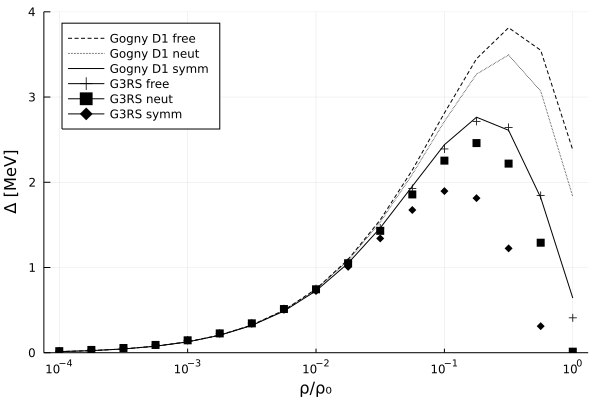

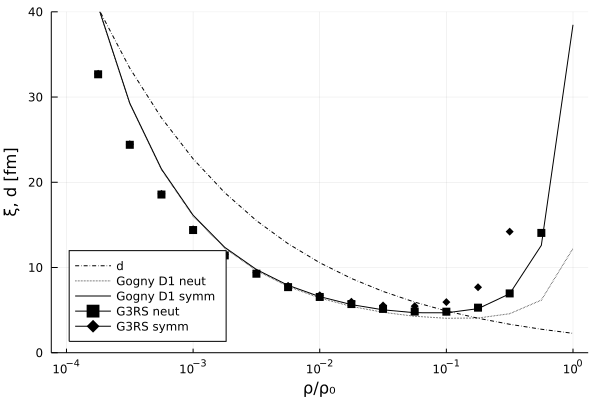

In [32]:
p = plot(;ylim=(0,4), xaxis=:log, xlabel="ρ/ρ₀", ylabel="Δ [MeV]", legend=:topleft)

plot!(p, var"ρ/ρ₀", ΔF_Gogny_free; label="Gogny D1 free", color=:black, line=:dash)
plot!(p, var"ρ/ρ₀", ΔF_Gogny_neut; label="Gogny D1 neut", color=:black, line=:dot)
plot!(p, var"ρ/ρ₀", ΔF_Gogny_symm; label="Gogny D1 symm", color=:black)

plot!(p, var"ρ/ρ₀", ΔF_G3RS_free; label="G3RS free", color=:black, line=false, marker=:+)
plot!(p, var"ρ/ρ₀", ΔF_G3RS_neut; label="G3RS neut", color=:black, line=false, marker=:square)
plot!(p, var"ρ/ρ₀", ΔF_G3RS_symm; label="G3RS symm", color=:black, line=false, marker=:diamond)
display(p)

p = plot(;ylim=(0, 40), xaxis=:log, xlabel="ρ/ρ₀", ylabel="ξ, d [fm]", legend=:bottomleft)
plot!(p, var"ρ/ρ₀", (@. (var"ρ/ρ₀"*param.ρ₀)^(-1/3)); label="d", color=:black, line=:dashdot)
plot!(p, var"ρ/ρ₀", ξ_Gogny_neut; label="Gogny D1 neut", color=:black, line=:dot)
plot!(p, var"ρ/ρ₀", ξ_Gogny_symm; label="Gogny D1 symm", color=:black)
plot!(p, var"ρ/ρ₀", ξ_G3RS_neut; label="G3RS neut", color=:black, line=false, marker=:square)
plot!(p, var"ρ/ρ₀", ξ_G3RS_symm; label="G3RS symm", color=:black, line=false, marker=:diamond)
display(p)

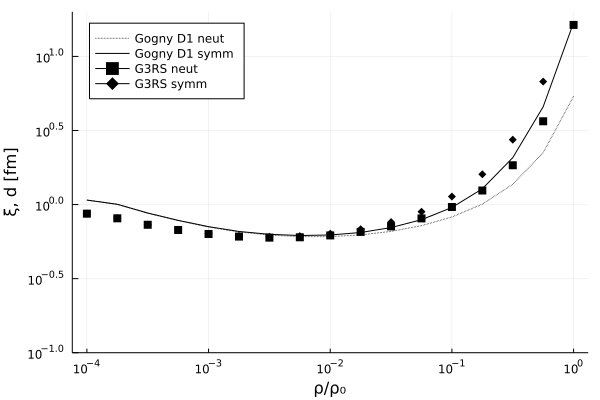

In [230]:
var"ρ/ρ₀" = 10 .^ range(-4, 0, step=0.25)
d = @. (var"ρ/ρ₀"*param.ρ₀)^(-1/3)

p = plot(;xaxis=:log, yaxis=:log, ylim=(0.1, 20), xlabel="ρ/ρ₀", ylabel="ξ, d [fm]", legend=:topleft)
#plot!(p, var"ρ/ρ₀", d; label="d", color=:black, line=:dashdot)
plot!(p, var"ρ/ρ₀", @. ξ_Gogny_neut/d; label="Gogny D1 neut", color=:black, line=:dot)
plot!(p, var"ρ/ρ₀", @. ξ_Gogny_symm/d; label="Gogny D1 symm", color=:black)
plot!(p, var"ρ/ρ₀", @. ξ_G3RS_neut/d; label="G3RS neut", color=:black, line=false, marker=:square)
plot!(p, var"ρ/ρ₀", @. ξ_G3RS_symm/d; label="G3RS symm", color=:black, line=false, marker=:diamond)
display(p)

In [155]:
function calc_wave_function!(ψ, param, es, Δs, μ)
    @unpack Δk, Nk, ks, Δr, Nr, rs = param
    
    fill!(ψ, 0)
    for ir in 1:Nr, ik in 1:Nk 
        r = rs[ir]
        
        k = ks[ik]
        Δ = Δs[ik]
        E = sqrt((es[ik]-μ)^2 + Δ^2)
        
        ψ[ir] += 1/(4π^2*r)*Δk*k*(Δ/E)*sin(k*r)
    end
    
    #=
    N = calc_norm(param, es, Δs, μ)
    N₂ = sqrt(sum(@. 4π*rs^2*ψ^2))
    @show N N₂
    =#
    
    # normalization 
    ψ ./= calc_norm(param, es, Δs, μ)
    ψ .*= sqrt(4π)
    return 
end


test_calc_wave_function (generic function with 1 method)

In [210]:
var"ρ/ρ₀" = 1/2

Nr = 200
Nk = 1000
Δk = 0.01

# Gogny for symmetric matter 
param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀", 
    Nr=Nr, Δk=Δk, Nk=Nk, interaction=:Gogny, spectrum=:symmetric)
@time es, Δs, μ = solve_gap_equation(param, Δ₀)
ψ_Gogny_symm = similar(rs)
@time calc_wave_function!(ψ_Gogny_symm, param, es, Δs, μ)

# G3RS for neutron matter
param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀", 
    Nr=Nr, Δk=Δk, Nk=Nk, interaction=:G3RS, spectrum=:symmetric)
@time es, Δs, μ = solve_gap_equation(param, Δ₀)
ψ_G3RS_symm = similar(rs)
@time calc_wave_function!(ψ_G3RS_symm, param, es, Δs, μ)

 10.484497 seconds (3.67 k allocations: 2.525 MiB)
  0.004851 seconds
 26.271371 seconds (7.33 k allocations: 10.446 MiB)
  0.005455 seconds


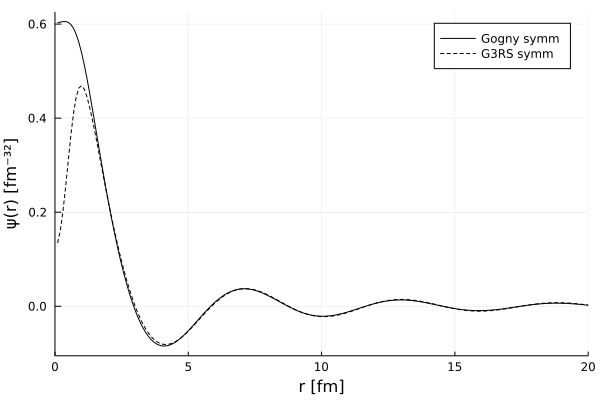

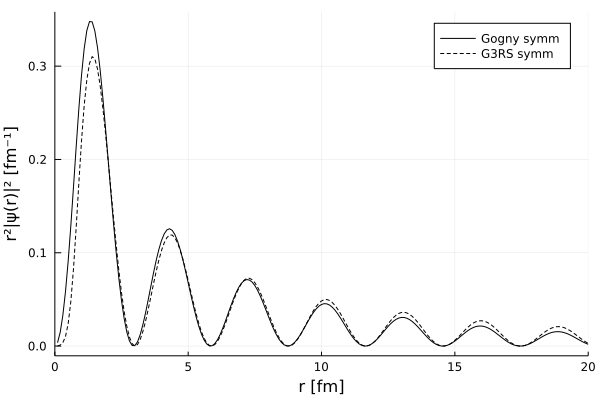

In [212]:
p = plot(;xlabel="r [fm]", ylabel="ψ(r) [fm⁻³²]", xlim=(0,20))
plot!(p, rs, ψ_Gogny_symm; label="Gogny symm", color=:black)
plot!(p, rs, ψ_G3RS_symm; label="G3RS symm", color=:black, line=:dash)
display(p)

p = plot(;xlabel="r [fm]", ylabel="r²|ψ(r)|² [fm⁻¹]", xlim=(0,20))
plot!(p, rs, (@. rs^2*ψ_Gogny_symm^2); label="Gogny symm", color=:black)
plot!(p, rs, (@. rs^2*ψ_G3RS_symm^2); label="G3RS symm", color=:black, line=:dash)
display(p)

In [213]:
Nr = 200
Nk = 1000
Δk = 0.01

# Gogny for symmetric matter 
param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀", 
    Nr=Nr, Δk=Δk, Nk=Nk, interaction=:Gogny, spectrum=:neutron)
@time es, Δs, μ = solve_gap_equation(param, Δ₀)
ψ_Gogny_neut = similar(rs)
@time calc_wave_function!(ψ_Gogny_neut, param, es, Δs, μ)

# G3RS for neutron matter
param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀", 
    Nr=Nr, Δk=Δk, Nk=Nk, interaction=:G3RS, spectrum=:neutron)
@time es, Δs, μ = solve_gap_equation(param, Δ₀)
ψ_G3RS_neut = similar(rs)
@time calc_wave_function!(ψ_G3RS_neut, param, es, Δs, μ)

  9.794587 seconds (3.35 k allocations: 2.315 MiB)
  0.004832 seconds
 24.468098 seconds (6.27 k allocations: 8.942 MiB)
  0.006198 seconds


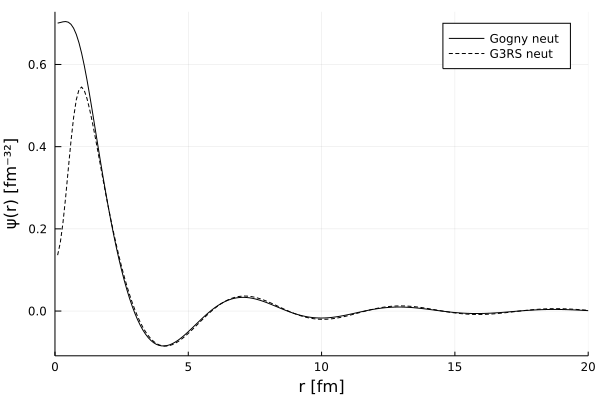

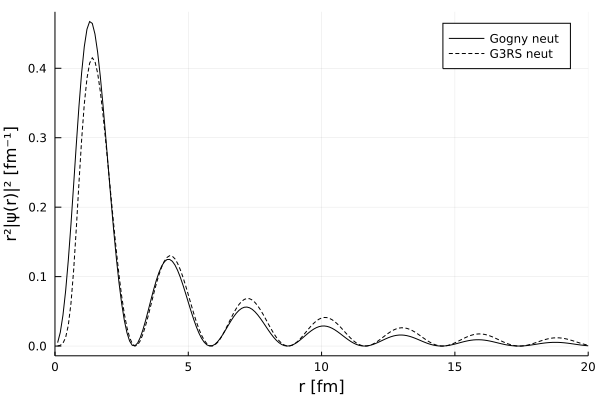

In [216]:
p = plot(;xlabel="r [fm]", ylabel="ψ(r) [fm⁻³²]", xlim=(0,20))
plot!(p, rs, ψ_Gogny_neut; label="Gogny neut", color=:black)
plot!(p, rs, ψ_G3RS_neut; label="G3RS neut", color=:black, line=:dash)
display(p)

p = plot(;xlabel="r [fm]", ylabel="r²|ψ(r)|² [fm⁻¹]", xlim=(0,20))
plot!(p, rs, (@. rs^2*ψ_Gogny_neut^2); label="Gogny neut", color=:black)
plot!(p, rs, (@. rs^2*ψ_G3RS_neut^2); label="G3RS neut", color=:black, line=:dash)
display(p)

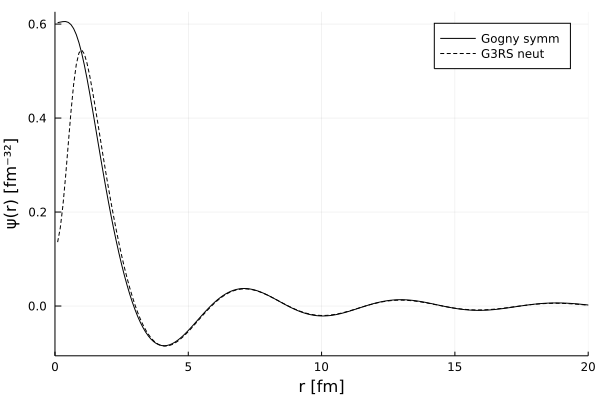

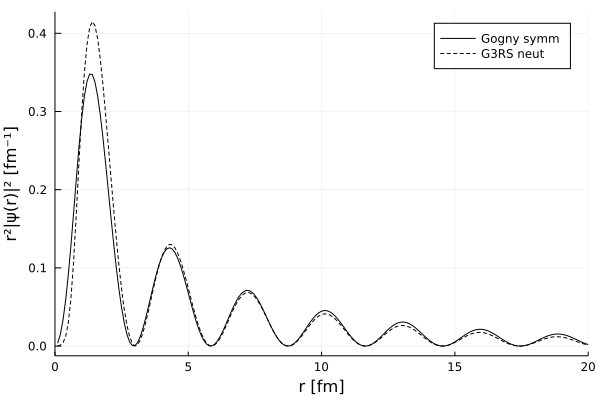

In [218]:
p = plot(;xlabel="r [fm]", ylabel="ψ(r) [fm⁻³²]", xlim=(0,20))
plot!(p, rs, ψ_Gogny_symm; label="Gogny symm", color=:black)
plot!(p, rs, ψ_G3RS_neut; label="G3RS neut", color=:black, line=:dash)
display(p)

p = plot(;xlabel="r [fm]", ylabel="r²|ψ(r)|² [fm⁻¹]", xlim=(0,20))
plot!(p, rs, (@. rs^2*ψ_Gogny_symm^2); label="Gogny symm", color=:black)
plot!(p, rs, (@. rs^2*ψ_G3RS_neut^2); label="G3RS neut", color=:black, line=:dash)
display(p)